# Gradient Symbolic Computation

see `TPR_example.ipynb` for details about the TP representation and one possible empirical phenomenon, that can be handled with GSC.

In [2]:
# Imports
from src.classes.Grammar import Grammar
from src.gsc.gsc_network import Net
import pandas as pd
import torch
# Set seed for reproducibility
torch.manual_seed(123)

## Grammar and Harmonic Constraints

In [3]:
# Fillers and Roles
fillers = ["bh", "b", "u", "d", "dh"]
roles = ["s1", "s2", "s3"]

similarities = torch.tensor([[1, 0.75, 0, 0, 0, 0],
                             [0.75, 1, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0, 0],
                             [0, 0, 0, 1, 0.75, 0],
                             [0, 0, 0, 0.75, 1, 0],
                             [0, 0, 0, 0, 0, 1]])

# Build Grammar
# G = Grammar(fillers, roles, emtpyFiller="#")
G = Grammar(fillers, roles, emtpyFiller="_", fillerSimilarities=similarities)

Buil Filler Matrix
Representations built after 392 attempts

Build role Matrix
Representations built after 177 attempts



__Single Constituents Harmony__

The following code sets the harmony values for single bindings. 
For instance the constraint `("b/s1", 2)` means that the segment "b" in first position ("s1") improves the general harmony by 2. 

There will be *Harmony crosstalk* if the vector representing those bindings are not independent (dot product == 0). Let's suppose that the vector representing "b/s1" has a non-null dotproduct with the vector representing "bh/s1". Then "bh/s1" will also improve its harmony by a factor $H_{b/s1} \times (b/s1 \cdot bh/s1)$


In [4]:
# Single Harmony constraints
cons = [("b/s1", 2), ("bh/s1", 2), ("u/s2", 5), ("d/s3", 2), ("dh/s3", 5)]
G.update_Hc(cons)

__Pairwise Harmony__

These constraints provide a way to declare Harmonic Constraints in the GSC. 
Ex.:

`("u/s2" "d/s3", -3)` means that the co-occurence of "u" in the secondo position and "d" in the third position makes the total Harmony decrease by -3 points. This  (indirectly) implement the preference for "dh" in "s3".


In [5]:
# Pairwise Harmony
# Matrix dim: (nF, nR, nF, nR)
cons = [("u/s2", "d/s3", -3),
        ("u/s2", "dh/s3", 3)]
G.update_Hcc(cons)

### Single binding Harmonies:

In [6]:
harmonies = G.Hc.numpy()
harmonies = pd.DataFrame(harmonies, columns=roles, index=fillers)
harmonies

,s1,s2,s3
bh,2.0,0.0,0.0
b,2.0,0.0,0.0
u,0.0,5.0,0.0
d,0.0,0.0,2.0
dh,0.0,0.0,5.0
_,0.0,0.0,0.0


In [7]:
import seaborn as sns

<AxesSubplot:>

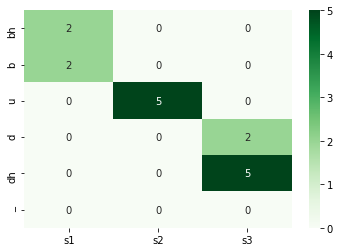

In [8]:
sns.heatmap(harmonies, annot=True, cmap="Greens")

### Pairwise Harmonies:

In [9]:
# Harmonies for the binding : u/s2
harmonies = G.Hcc.numpy()[:,:,2,1]
harmonies = pd.DataFrame(harmonies, columns=roles, index=fillers)
harmonies

,s1,s2,s3
bh,0.0,0.0,0.0
b,0.0,0.0,0.0
u,0.0,0.0,0.0
d,0.0,0.0,-3.0
dh,0.0,0.0,3.0
_,0.0,0.0,0.0


<AxesSubplot:>

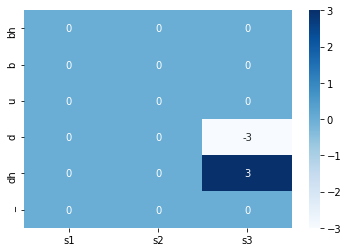

In [10]:
sns.heatmap(harmonies, annot=True, cmap="Blues")

The preceding matrix is the matrix for "u" in second position, the binding "u/s2". We implemented the harmony constraint ("u/s2", "d/s3", -3) and ("u/s2", "dh/s3", 3) and this is what the heatmap is visualizing.

## GSC Net

In [11]:
# Custom settings (these substitute the hard-coded settings)

# ---------------------------------------
#           GSC NET
# ---------------------------------------

custom_settings = {"epochs": 5,
                   "tgtStd": 0.00125,
                   "emaFactor": 0.05,
                   "emaSpeedTol": 0.002,
                   "dt": 1e-5,
                   "T_decay_rate": 0.05,
                   "maxSteps": 50000,
                   "printInterval": 25000}
# Initialize
N = Net(G, custom_settings=custom_settings, extData_path="data/inp_pandas.csv")


Input processed: b-bh-u-dh

Input processed: b-u-dh

Value for Q set to 16.26776109327919
LAMBDA RECOMMENDED: 0.01422198802943719, ACTUAL LAMBDA = 0.011387


If you want to change to the recommended Lambda value press 'y', else any other key: y


T RECOMMENDED: 2.3761105810755308e-05, ACTUAL T = -1


If you want to change to the recommended value press 'y', else any other key: y


The external data were provided in form of a simple csv file and were imported in the GSCNet using `pandas`:

In [12]:
# EXTERNAL INPUTS 

# Read dataframe
inputs = pd.read_csv("data/inp_pandas.csv", sep=",")
inputNames = []
nStimuli = len(inputs['id'].unique())

# Initialize stimuli tensor
stimuli = torch.zeros((nStimuli, len(fillers) + 1, len(roles)))

# Loop over the single inputs as whole
for idx, i in enumerate(inputs['id'].unique()):
    inp_string = ""
    stimulus = inputs[inputs.id == i].to_numpy()[:, 1:]

    # Loop over the fillers in a given input
    for filler in stimulus:
        fidx = N.filler2index[filler[0]]
        inp_string += filler[0] + "-"
        for roledix in range(N.grammar.bind.nR):
            stimuli[idx, fidx, roledix] = filler[roledix+1]
    print(f"Input processed: {inp_string[:-1]}\n")
    # Store the names for later plotting
    inputNames.append(inp_string[:-1])

Input processed: b-bh-u-dh

Input processed: b-u-dh



The first imput is a gradient blend for the root *{b, bh}ud*:

     s1   s2   s3
bh  0.7  0.0  0.0
b   0.8  0.0  0.0
u   0.0  1.0  0.0
d   0.0  0.0  0.0
dh  0.0  0.0  1.0
_   0.0  0.0  0.0


<AxesSubplot:>

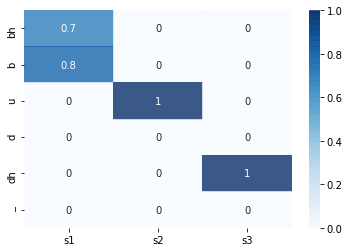

In [13]:
b_bh_ud = N.stimuli[0,:,:].numpy()
b_bh_ud = pd.DataFrame(b_bh_ud, columns=roles, index=fillers)
print(b_bh_ud)
sns.heatmap(b_bh_ud, alpha=.8, cmap="Blues", annot=True)

## Training (Optimization + Quantization)

In [14]:
# Run
p = N()

Stimulus routine::   0%|          | 0/2 [00:00<?, ?it/s]


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.01422198802943719	 Harmony: 40.88941192626953

epoch : 1
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.695062  0.400000  0.400000
b   0.696599  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.955837828969228

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.014093308807301778	 Harmony: 40.876956939697266

epoch : 1
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.694129  0.408168  0.412031
b   0.696169  0.402407  0.404286
u   0.399662  0.778998  0.406404
d   0.398988  0.411017  0.780703
dh  0.399276  0.406963  0.906658
_   0.398751  0.414330  0.421765
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.9


Stimulus routine::  50%|█████     | 1/2 [00:01<00:01,  1.20s/it]


Last best Harmony: 40.839402375524735


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.013965675056728579	 Harmony: 40.293277740478516

epoch : 1
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.661253  0.400000  0.400000
b   0.676621  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.9461598997996337

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.013839331352360405	 Harmony: 40.28062438964844

epoch : 1
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.660280  0.408101  0.412618
b   0.676046  0.402790  0.404189
u   0.399908  0.778861  0.406458
d   0.399681  0.411814  0.781561
dh  0.398765  0.406338  0.906030
_   0.398797  0.414205  0.421432
Nearest TP: b-u-dh
Dista


Stimulus routine::   0%|          | 0/2 [00:00<?, ?it/s]


Last best Harmony: 40.242898376415134


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.013714014144327753	 Harmony: 40.88941192626953

epoch : 2
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.695062  0.400000  0.400000
b   0.696599  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.955837828969228

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.013589963568262893	 Harmony: 40.876773834228516

epoch : 2
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.694276  0.408289  0.412463
b   0.696015  0.402349  0.403680
u   0.399589  0.779197  0.406568
d   0.399389  0.411862  0.781472
dh  0.399039  0.406280  0.906381
_   0.399026  0.414007  0.421521
Nearest TP: b-u-dh
Distan


Stimulus routine::  50%|█████     | 1/2 [00:01<00:01,  1.21s/it]


Last best Harmony: 40.83918398041319


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.013466920857705792	 Harmony: 40.293277740478516

epoch : 2
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.661253  0.400000  0.400000
b   0.676621  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.9461598997996337

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.013345121789845812	 Harmony: 40.28091049194336

epoch : 2
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.660648  0.407822  0.412883
b   0.675894  0.402803  0.403560
u   0.399454  0.779147  0.406079
d   0.399527  0.411146  0.780871
dh  0.399137  0.407043  0.906810
_   0.398985  0.414011  0.421233
Nearest TP: b-u-dh
Distan


Stimulus routine::   0%|          | 0/2 [00:00<?, ?it/s]


Last best Harmony: 40.2438783114262


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.013224312294813809	 Harmony: 40.88941192626953

epoch : 3
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.695062  0.400000  0.400000
b   0.696599  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.955837828969228

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.01310472387046173	 Harmony: 40.87682342529297

epoch : 3
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.694093  0.408586  0.412421
b   0.696461  0.402405  0.404254
u   0.399438  0.778922  0.406485
d   0.398737  0.411640  0.780937
dh  0.399731  0.406480  0.906615
_   0.398930  0.413915  0.421694
Nearest TP: b-u-dh
Distance b


Stimulus routine::  50%|█████     | 1/2 [00:01<00:01,  1.20s/it]


Last best Harmony: 40.839545990179026


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.012986107058268618	 Harmony: 40.293277740478516

epoch : 3
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.661253  0.400000  0.400000
b   0.676621  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.9461598997996337

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.012868689154418585	 Harmony: 40.280574798583984

epoch : 3
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.660317  0.408105  0.412496
b   0.676259  0.402357  0.404556
u   0.399678  0.779299  0.406817
d   0.398782  0.411587  0.781048
dh  0.399687  0.406692  0.906880
_   0.399151  0.414462  0.421331
Nearest TP: b-u-dh
Dist


Stimulus routine::   0%|          | 0/2 [00:00<?, ?it/s]


Last best Harmony: 40.24332263843204


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.012752225228043175	 Harmony: 40.88941192626953

epoch : 4
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.695062  0.400000  0.400000
b   0.696599  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.955837828969228

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.012636938449918669	 Harmony: 40.87691116333008

epoch : 4
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.693993  0.407547  0.413250
b   0.696102  0.403092  0.403858
u   0.399519  0.778804  0.406134
d   0.398912  0.411266  0.780886
dh  0.399866  0.406642  0.906791
_   0.399077  0.414016  0.421508
Nearest TP: b-u-dh
Distance


Stimulus routine::  50%|█████     | 1/2 [00:01<00:01,  1.20s/it]


Last best Harmony: 40.83964117395866


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.012522588334652598	 Harmony: 40.293277740478516

epoch : 4
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.661253  0.400000  0.400000
b   0.676621  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.9461598997996337

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.012409394002489214	 Harmony: 40.280738830566406

epoch : 4
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.660405  0.407920  0.412688
b   0.676380  0.402685  0.403876
u   0.399861  0.779068  0.406859
d   0.399073  0.411004  0.781177
dh  0.399493  0.406929  0.906580
_   0.399096  0.413977  0.421557
Nearest TP: b-u-dh
Dista


Stimulus routine::   0%|          | 0/2 [00:00<?, ?it/s]


Last best Harmony: 40.24341327671468


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.012297119332827016	 Harmony: 40.88941192626953

epoch : 5
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.695062  0.400000  0.400000
b   0.696599  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.955837828969228

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.012185979468895011	 Harmony: 40.87688446044922

epoch : 5
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.694320  0.408185  0.412160
b   0.696326  0.402680  0.404298
u   0.399386  0.779141  0.406786
d   0.399481  0.411194  0.781418
dh  0.398957  0.406907  0.906654
_   0.399161  0.413894  0.421380
Nearest TP: b-u-dh
Distance


Stimulus routine::  50%|█████     | 1/2 [00:01<00:01,  1.18s/it]


Last best Harmony: 40.839577480385216


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.012075742575662084	 Harmony: 40.293277740478516

epoch : 5
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.661253  0.400000  0.400000
b   0.676621  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.9461598997996337

--------------------------------------------------------------------------------

STEP : 1000	 Lambda : 0.011966619891524557	 Harmony: 40.28062438964844

epoch : 5
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.660228  0.408145  0.412943
b   0.676417  0.402464  0.403950
u   0.399463  0.779175  0.406313
d   0.399203  0.411861  0.781222
dh  0.399459  0.406450  0.906424
_   0.399565  0.413981  0.421535
Nearest TP: b-u-dh
Dista


Epoch routine:: 100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


Last best Harmony: 40.24294665887766



# Visualization

In [15]:
# Load the Plot class
from src.gsc.plotting import Plot
import matplotlib.pyplot as plt

plot = Plot(net=N, fp_traces="data/full_traces.pt")

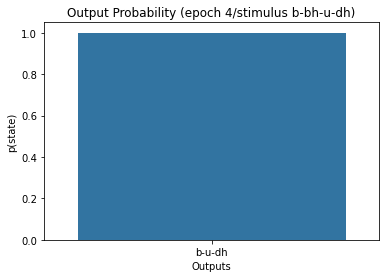

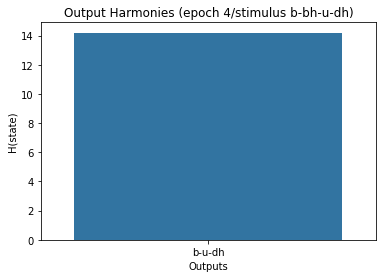

In [16]:
# Probabilities and Harmonies
# input {b,bh}-u-d, training_epoch = 5
plot.plotTP_probs(stim=0, epoch=4)

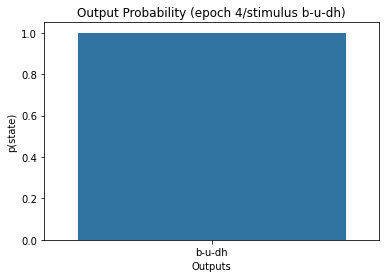

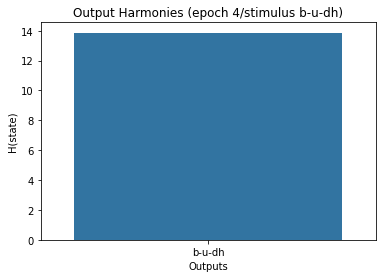

In [17]:
# input b-u-dh, training_epoch = 5
plot.plotTP_probs(stim=1, epoch=4)